In [1]:
# !pip install mxnet-cu92 --pre --upgrade
# !pip install gluoncv --pre

In [2]:
import time
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon, nd, image
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import download, viz
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

## Classification with multiple objects

Classification does an excellent job for images with a main object. However, what if the input photo contains multiple objects?

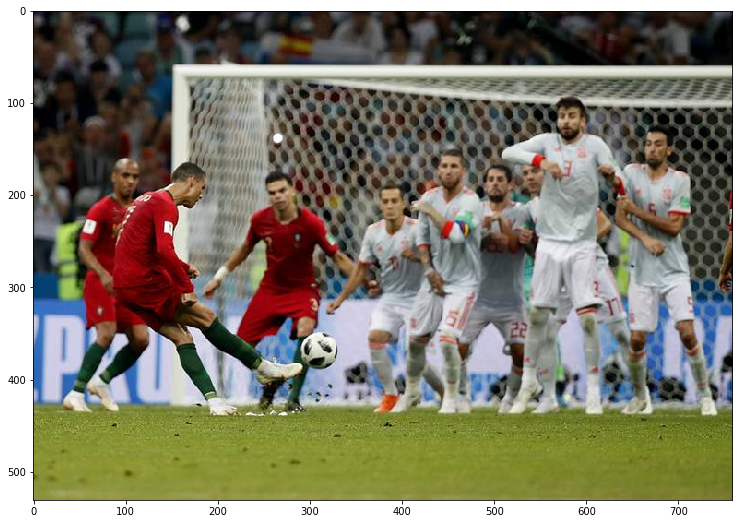

In [3]:
plt.rcParams['figure.figsize'] = (15, 9)

img = image.imread('cr7.jpg')
viz.plot_image(img)
plt.show()

We predict with image classification algorithm.

In [4]:
model_name = 'ResNet50_v1'
net = gluoncv.model_zoo.get_model(model_name, pretrained=True)

transformed_img = gluoncv.data.transforms.presets.imagenet.transform_eval(img)

pred = net(transformed_img)
prob = mx.nd.softmax(pred)[0].asnumpy()
ind = mx.nd.topk(pred, k=5)[0].astype('int').asnumpy().tolist()
print('The input picture is classified to be')
for i in range(5):
    print('- [%s], with probability %.3f.'%(net.classes[ind[i]], prob[ind[i]]))

The input picture is classified to be
- [soccer ball], with probability 0.434.
- [ballplayer], with probability 0.203.
- [basketball], with probability 0.027.
- [baseball], with probability 0.027.
- [rugby ball], with probability 0.022.


The model's best guess is just "soccer ball". This is not how we describe the image.

## Try Object Detection

Next, let's try to use object detection to detect the multiple objects.

Firstly we again load the image in and preprocess it at the same time. Here the `short=512` means we resize the short edge to 512 pixels while keeping the aspect ratio.

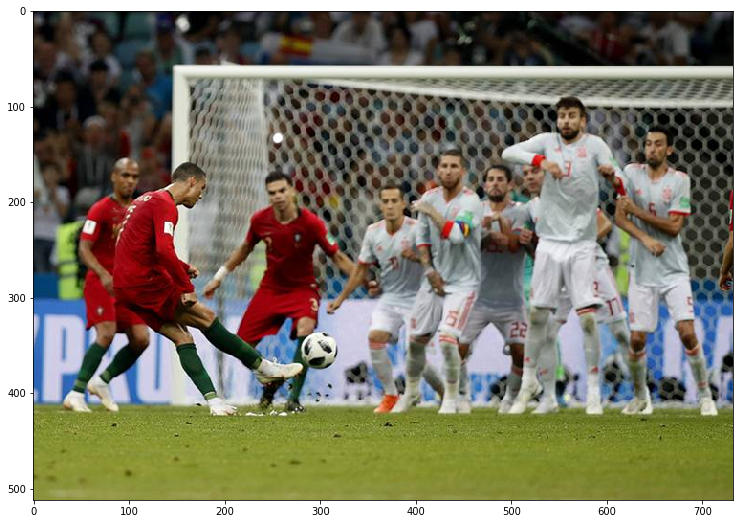

In [5]:
x, img = gluoncv.data.transforms.presets.ssd.load_test('cr7.jpg', short=512)
viz.plot_image(img)
plt.show()

Next, we download a pretraiend SSD. Here `ssd_512_resnet50_v1_coco` is a combination of:

1. `ssd`: the name of the model
2. `512`: the length of the short edge
3. `resnet50_v1`: the base model
4. `coco`: the dataset on which the model is trained

In [6]:
net = get_model('ssd_512_resnet50_v1_coco', pretrained=True)

The output contains the predicted classes, the confident scores and the location of bounding boxes.

With `gluoncv.utils.viz` we can easily visualize the result.

One interesting finding is that the algorithm can even detect the blurred out audiences in the background. Although their scores are lower.

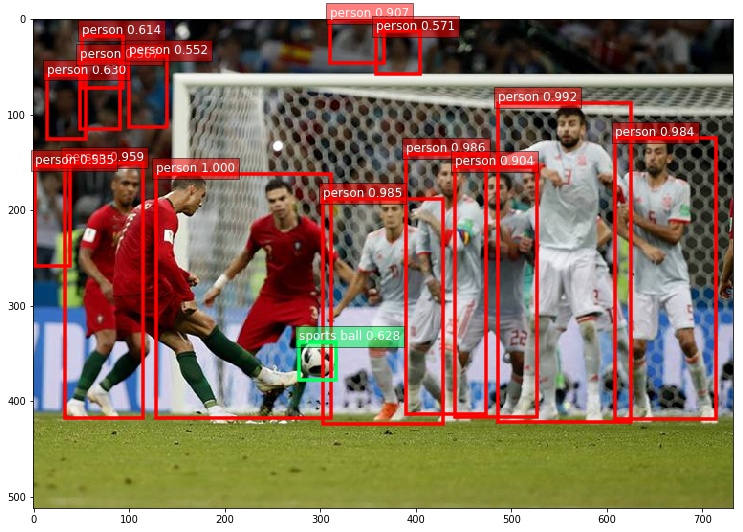

In [7]:
class_IDs, scores, bounding_boxs = net(x)
viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

Another example: this is a photo taken in our Palo Alto office during world cup 2018.

We can detect and count how many are watching the game instead of going back to work.

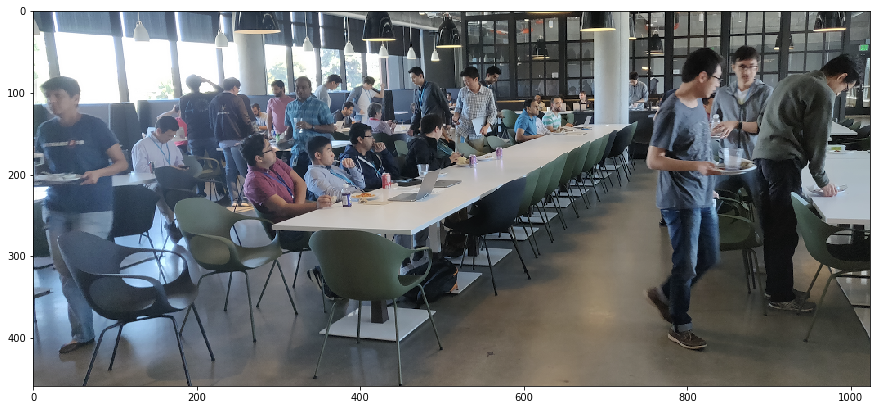

In [8]:
x, img = gluoncv.data.transforms.presets.ssd.load_test('crowd.png', short=512)
viz.plot_image(img)
plt.show()

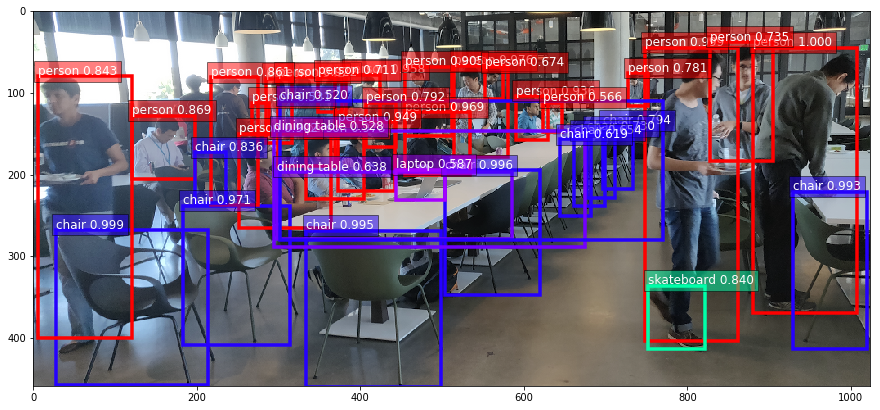

In [9]:
class_IDs, scores, bounding_boxs = net(x)
viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

We can select all boxes containing a `person` count.

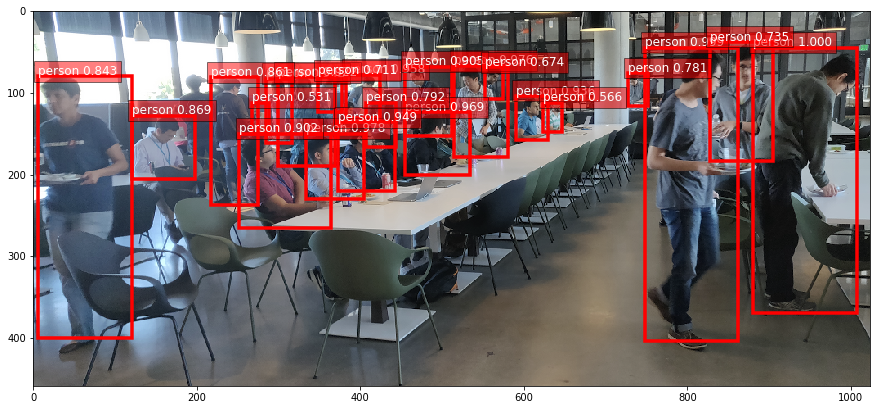

There are 33 people in this photo.


In [10]:
class_IDs, scores, bounding_boxs = net(x)
person_ind = [i for i, cls in enumerate(net.classes) if cls == 'person']
ind = np.nonzero(class_IDs[0].asnumpy() == person_ind)[0]

new_class_IDs = class_IDs[0][ind]
new_scores = scores[0][ind]
new_bounding_boxs = bounding_boxs[0][ind]

viz.plot_bbox(img, new_bounding_boxs, new_scores, new_class_IDs, class_names=net.classes)
plt.show()

print('There are %d people in this photo.'%(len(ind)))

Detection can also be used in outdoor scenario. For example this is a photo of our Palo Alto office.

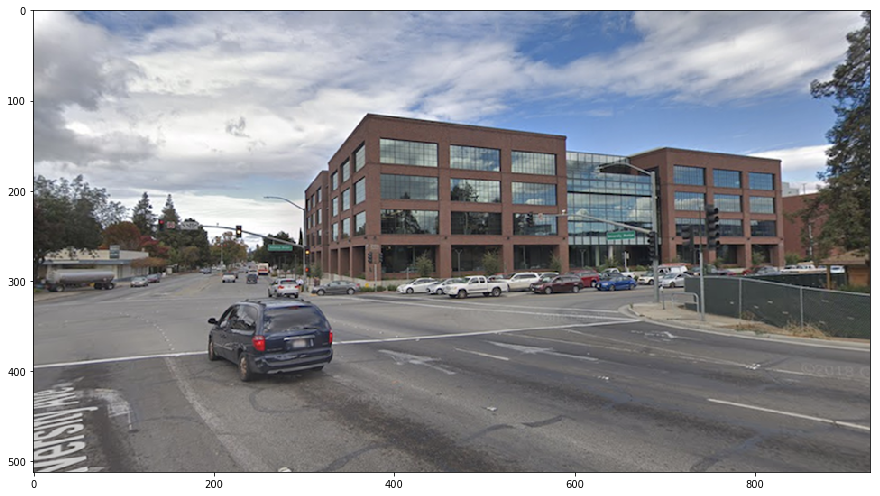

In [11]:
x, img = gluoncv.data.transforms.presets.ssd.load_test('streetview_amazon.png', short=512)
viz.plot_image(img)
plt.show()

We can detect the cars, trucks and traffic lights.

Guess where can we apply it to? Automated Driving!

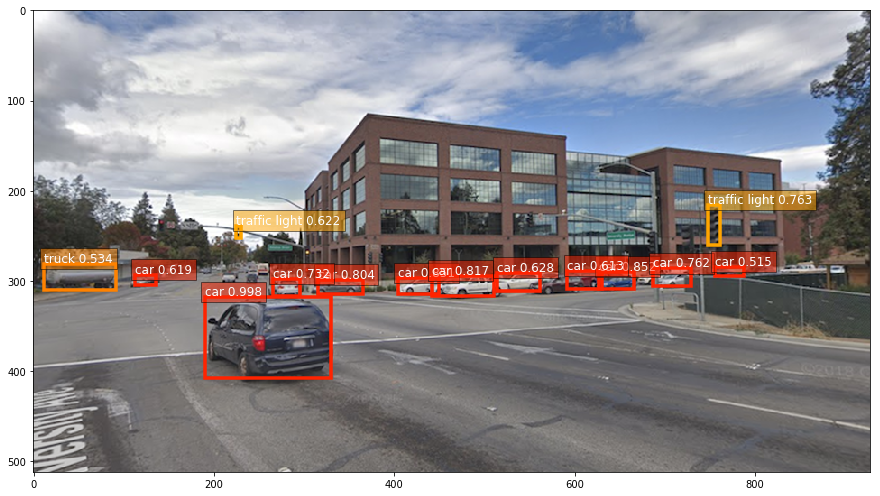

In [12]:
class_IDs, scores, bounding_boxs = net(x)
viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

## Train your own model to detect Pikachu

Pre-trained models only recognize the type of objects in the dataset. What if you have your own object of interests and want to train a model for that?

No problem! We'll show an example of teaching a pre-trained model to recognize Pikachu.

First we download the small dataset.

In [13]:
url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.rec'
idx_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx'
download(url, path='pikachu_train.rec', overwrite=False)
download(idx_url, path='pikachu_train.idx', overwrite=False)

'pikachu_train.idx'

Next we load in the dataset and show how it looks like.

label: [[214.70685 132.91504 271.07706 215.32448   0.     ]]


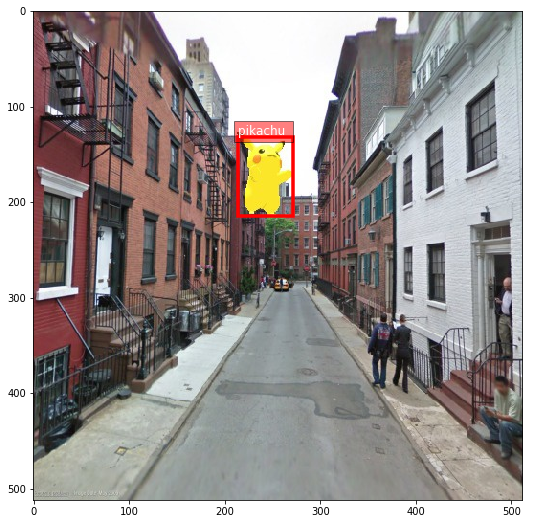

In [14]:
dataset = gluoncv.data.RecordFileDetection('pikachu_train.rec')
classes = ['pikachu']  # only one foreground class here
image, label = dataset[1]
print('label:', label)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

Basically we chose some landscape photos and copy an open-sourced Pikachu figure onto the image.

We load in a pretrained `ssd_512_mobilenet1.0_voc` model and reset its output layer.

In [15]:
net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)
net.reset_class(classes)
net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes,
    pretrained_base=False, transfer='voc')

Next we define the dataloader.

In [16]:
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, dataset, 512, 16, 0)

We encourage to use GPU for the training.

In [17]:
ctx = [mx.gpu(0)]
net.collect_params().reset_ctx(ctx)

Next we define the trainer, loss and metric.

In [18]:
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})
mbox_loss = gluoncv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

Everything's prepared. We can start training now. We just need 2 epochs for this dataset.

In [19]:
for epoch in range(0, 2):
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize(static_alloc=True, static_shape=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        with autograd.record():
            cls_preds = []
            box_preds = []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)
        # since we have already normalized the loss, we don't want to normalize
        # by batch-size anymore
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if i % 1 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        btic = time.time()

net.save_parameters('ssd_512_mobilenet1.0_pikachu.params')

[Epoch 0][Batch 0], Speed: 3.187 samples/sec, CrossEntropy=7.848, SmoothL1=1.758
[Epoch 0][Batch 1], Speed: 23.103 samples/sec, CrossEntropy=7.009, SmoothL1=2.131
[Epoch 0][Batch 2], Speed: 26.272 samples/sec, CrossEntropy=6.494, SmoothL1=1.996
[Epoch 0][Batch 3], Speed: 23.810 samples/sec, CrossEntropy=6.144, SmoothL1=1.942
[Epoch 0][Batch 4], Speed: 21.310 samples/sec, CrossEntropy=5.837, SmoothL1=1.891
[Epoch 0][Batch 5], Speed: 24.496 samples/sec, CrossEntropy=5.606, SmoothL1=1.877
[Epoch 0][Batch 6], Speed: 21.242 samples/sec, CrossEntropy=5.402, SmoothL1=1.846
[Epoch 0][Batch 7], Speed: 24.172 samples/sec, CrossEntropy=5.205, SmoothL1=1.744
[Epoch 0][Batch 8], Speed: 23.632 samples/sec, CrossEntropy=5.041, SmoothL1=1.663
[Epoch 0][Batch 9], Speed: 25.073 samples/sec, CrossEntropy=4.880, SmoothL1=1.605
[Epoch 0][Batch 10], Speed: 20.212 samples/sec, CrossEntropy=4.725, SmoothL1=1.552
[Epoch 0][Batch 11], Speed: 21.496 samples/sec, CrossEntropy=4.599, SmoothL1=1.537
[Epoch 0][Batch

Finished!

We have a test image with multiple Pikachus. Let's see if we can detect all of them.

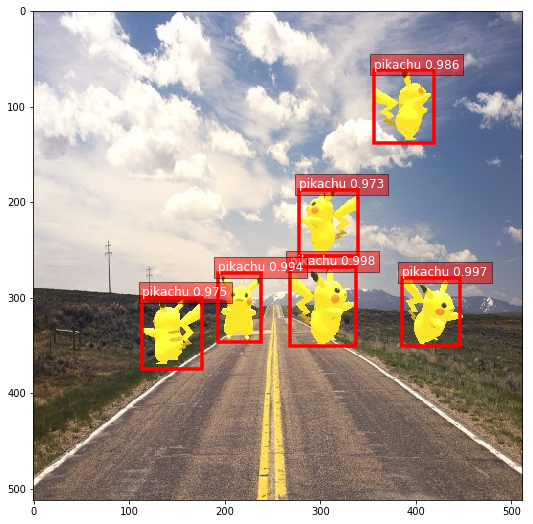

In [20]:
test_url = 'https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/pikachu.jpg'
download(test_url, 'pikachu_test.jpg')
net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_pikachu.params')
x, image = gluoncv.data.transforms.presets.ssd.load_test('pikachu_test.jpg', 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()